In [1]:
import pandas as pd
import numpy as np
import zipfile
import gzip
import shutil
from Bio import SeqIO
from itertools import chain
import matplotlib.pyplot as plt
import re
from matplotlib_venn import venn2, venn3
import os
import copy
#from Bio.Align import substitution_matrices
#from Bio import Align
#aligner = Align.PairwiseAligner()
#aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
import glob
from pyteomics import mgf
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle
from collections import Counter
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import textwrap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import regex
from pyteomics import mass

In [2]:
import  pyteomics
from pyteomics import pepxml, auxiliary
import pickle
import pandas as pd
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib_venn import venn3

In [89]:
project_palette={"canon":"orangered","trembl":"yellowgreen","openprot":"cornflowerblue"}

In [4]:
work_dir="./tpp_pride_reanalysis/"
work_subdirs=["PXD002057/","PXD003594-tpp/","PXD014258/"]

In [48]:
def combine_tpp(work_dir,work_subdir,database,file_sufix):
    '''
    file_sufix: _PeptideProphet.pep.xml | 
    '''
    path = os.path.join(work_dir, work_subdir, f'{work_subdir[0:9]}-{database}')
    toread=[os.path.join(lvl1[0],lvl2) for lvl1 in os.walk(path) for lvl2 in lvl1[2] if lvl2.endswith(file_sufix)]
    #print(toread)
    combined=pd.DataFrame()
    for file in toread:
        #print(file)
        a=pyteomics.pepxml.DataFrame(file)
        v=re.sub(f"\{file_sufix}$", "", file.lstrip(path))+".mgf"
        a['spectrum_file']=v#file.lstrip(path).rstrip(file_sufix)+".mgf"
        combined=pd.concat([combined,a])
    return combined

In [47]:
a="sample_01_merged_canon_PeptideProphet.pep.xml"
file_sufix="_canon_PeptideProphet.pep.xml"
re.sub(f"\{file_sufix}$", "",a )

'sample_01_merged'

In [49]:
peptideprophet_combined_datasets={"PXD002057":0,"PXD003594":0,"PXD014258":0}
file_sufix="PeptideProphet.pep.xml"
for work_subdir in work_subdirs:
    databases={"canon":0,"trembl":0,"openprot":0}
    for database in databases:
        databases[database]=combine_tpp(work_dir,work_subdir,database,f"_{database}_{file_sufix}")
    peptideprophet_combined_datasets[work_subdir[0:9]]=databases

In [191]:
#filter
peptideprophet_filt_combined_datasets={"PXD002057":{},"PXD003594":{},"PXD014258":{}}
for dataset_name in peptideprophet_combined_datasets:
    for database in peptideprophet_combined_datasets[dataset_name]:
        df=peptideprophet_combined_datasets[dataset_name][database]
        peptideprophet_filt_combined_datasets[dataset_name][database]=df.loc[df['peptideprophet_probability']>0.9,:]

In [ ]:
#ID rate

In [77]:
def get_idrate(mgfFiles, df):    
    IDrate={}
    for file in mgfFiles:
        if "RAW" in file:
            sup=re.sub(f"\{'.RAW.mgf'}$", "", file)
        sup=re.sub(f"\{'.mgf'}$", "", file)
        #print(sup)
        id=np.sum([1 for sp in df.spectrum if sup in sp])
        IDrate[file]=id/mgfFiles[file]
    return IDrate

In [81]:
mgfspectraN_datasets=pickle.load(open('mgfspectraN_datasets.pickle', 'rb'))

In [82]:
#as tpp does not save spectra by separate file (but merged, input), then add corresponding files n spectra
mgfspectraN_datasets['PXD003594.v0.11.4']={f'sample_{i}_merged.mgf':mgfspectraN_datasets['PXD003594.v0.11.4'][f'b1369p080_sample_{i}_a.mgf']+mgfspectraN_datasets['PXD003594.v0.11.4'][f'b1369p080_sample_{i}_b.mgf'] for i in ["01","02","03","04","05","06","07","08","09","10","11","12","13","14"]}
tmp={}
for i in ["ESC-HF-Sample-BT474","ESC-HF-SampleHela","ESC-HF-Sample-MCF"]:
    if "BT474" not in i:
        tmp[f"{i}_merged.mgf"]=np.sum([mgfspectraN_datasets['PXD014258.v0.11.4'][f"{i}{j}.RAW.mgf"] for j in range(1,6)])
    else:
        tmp[f"{i}_merged.mgf"]=np.sum([mgfspectraN_datasets['PXD014258.v0.11.4'][f"{i}_{j}.RAW.mgf"] for j in range(1,6)])
mgfspectraN_datasets['PXD014258.v0.11.4']=tmp
mgfspectraN_datasets

{'PXD002057.v0.11.4': {'130327_o2_03_hu_C2_2hr.mgf': 24764,
  '130327_o2_04_hu_P2_2hr.mgf': 26307,
  '130327_o2_06_hu_P3_2hr.mgf': 26558,
  '130327_o2_01_hu_C1_2hr.mgf': 25783,
  '130327_o2_05_hu_C3_2hr.mgf': 25052,
  '130327_o2_02_hu_P1_2hr.mgf': 26717},
 'PXD003594.v0.11.4': {'sample_01_merged.mgf': 38482,
  'sample_02_merged.mgf': 42821,
  'sample_03_merged.mgf': 13669,
  'sample_04_merged.mgf': 21647,
  'sample_05_merged.mgf': 53575,
  'sample_06_merged.mgf': 54799,
  'sample_07_merged.mgf': 52299,
  'sample_08_merged.mgf': 48152,
  'sample_09_merged.mgf': 31604,
  'sample_10_merged.mgf': 49413,
  'sample_11_merged.mgf': 49511,
  'sample_12_merged.mgf': 41357,
  'sample_13_merged.mgf': 38670,
  'sample_14_merged.mgf': 41529},
 'PXD014258.v0.11.4': {'ESC-HF-Sample-BT474_merged.mgf': 109777,
  'ESC-HF-SampleHela_merged.mgf': 100052,
  'ESC-HF-Sample-MCF_merged.mgf': 110917}}

In [83]:
#median across merged samples
peprideprophet_idrate_datasets={"PXD002057":0,"PXD003594":0,"PXD014258":0}
for dataset_name in peptideprophet_combined_datasets:
    idrate_med={"canon":0,"trembl":0,"openprot":0}
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets[key]
    for database in idrate_med:
        df=peptideprophet_combined_datasets[dataset_name][database]
        idrate_med[database]=np.median(list(get_idrate(mgfspectraN, df).values()))
    peprideprophet_idrate_datasets[dataset_name]=idrate_med

In [84]:
peprideprophet_idrate_datasets

{'PXD002057': {'canon': 0.06184871347619641,
  'trembl': 0.05969265584373567,
  'openprot': 0.04206729144807763},
 'PXD003594': {'canon': 0.008274427692082122,
  'trembl': 0.007957793303037333,
  'openprot': 0.007098809857780759},
 'PXD014258': {'canon': 0.07503809154593075,
  'trembl': 0.07294643742618354,
  'openprot': 0.06344383638215963}}

In [86]:
idrate_med_error={"canon":0,"trembl":0,"openprot":0}
idrate_med_avarage={"canon":0,"trembl":0,"openprot":0}
idrate_med_swarmplot={"canon":0,"trembl":0,"openprot":0}
for database in idrate_med_error:
    medians=[]
    for dataset_name in ['PXD003594','PXD002057','PXD014258']:
        a=round(peprideprophet_idrate_datasets[dataset_name][database],3)
        medians.append(a)
    idrate_med_error[database]=stats.sem(medians, axis=None, ddof=0)
    idrate_med_avarage[database]=np.mean(medians)
    idrate_med_swarmplot[database]=medians

In [237]:
0.2806666666666667-0.037333333333333336

0.24333333333333335

In [234]:
idrate_med_avarage

{'canon': 0.04833333333333334,
 'trembl': 0.04700000000000001,
 'openprot': 0.037333333333333336}

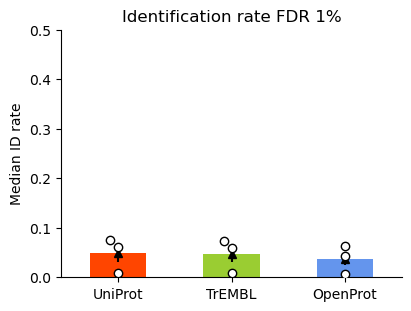

In [233]:
dbs = ("UniProt", "TrEMBL", "OpenProt")
x=np.array(range(len(dbs)))
y=idrate_med_avarage.values()
fig, ax = plt.subplots(layout='constrained', figsize=(4, 3))
width=0.5
ax.bar(x, y, width=width, color=project_palette.values())
ax.errorbar(x, y, yerr=list(idrate_med_error.values()), fmt="^",color="black")
sns.swarmplot(ax=ax,x=[0]*3+[1]*3+[2]*3, y=np.array(list(idrate_med_swarmplot.values())).flatten(),color="white",size=6, edgecolor='black',linewidth=1)
ax.set_ylabel('Median ID rate')
ax.set_title('Identification rate FDR 1%')
ax.set_xticks(x, dbs)
plt.ylim(0,0.5) #as in ionbot
for i,spine in enumerate(plt.gca().spines.values()):
    if i==1 or i==3:
        spine.set_visible(False)
plt.savefig("tpp_idrate_errorbar.svg")

In [ ]:
#PSMs, peptide overlap between searches

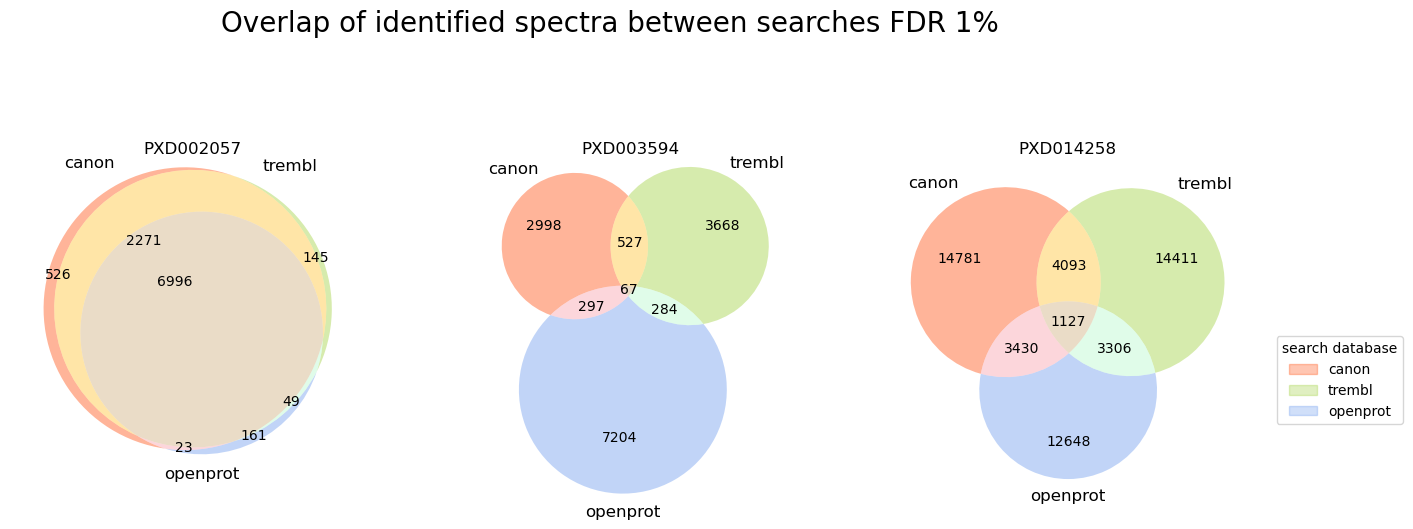

In [95]:
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle('Overlap of identified spectra between searches FDR 1%',size=20, y=0.9);
for i, dataset_name in enumerate(peptideprophet_combined_datasets):
    dfs=list(peptideprophet_combined_datasets[dataset_name].values())
    databases=list(peptideprophet_combined_datasets[dataset_name].keys())
    venn3([set(dfs[0].spectrum),set(dfs[1].spectrum),set(dfs[2].spectrum)], ax=axes[i],
      set_labels=[databases[0],databases[1],databases[2]], set_colors=(project_palette[databases[0]],project_palette[databases[1]],project_palette[databases[2]]))
    axes[i].set_title(f"{dataset_name}")
p=[]
for l,c in project_palette.items():
    p.append(mpatches.Patch(color=c, label=l,alpha=0.3))  
fig.legend(handles=p, title="search database",loc='upper right',bbox_to_anchor=(1, 0.5));
plt.savefig("tpp_spectra_venn.svg")

In [ ]:
#such difference because of number of spectra?

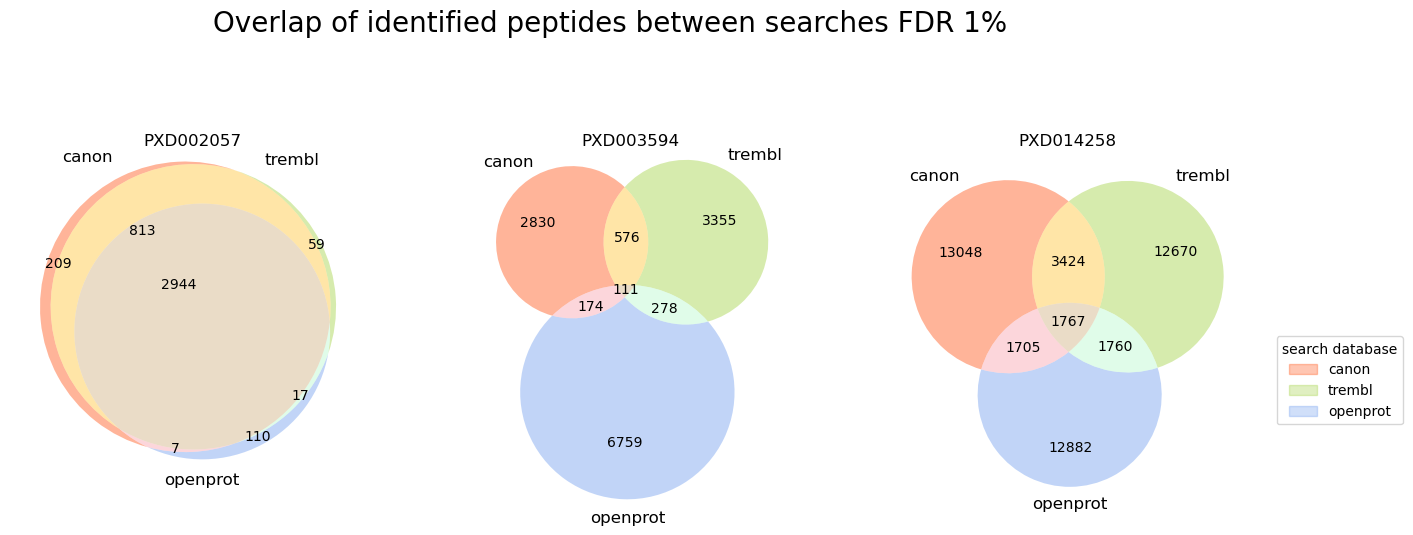

In [96]:
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle('Overlap of identified peptides between searches FDR 1%',size=20, y=0.9);
for i, dataset_name in enumerate(peptideprophet_combined_datasets):
    dfs=list(peptideprophet_combined_datasets[dataset_name].values())
    databases=list(peptideprophet_combined_datasets[dataset_name].keys())
    venn3([set(dfs[0].peptide),set(dfs[1].peptide),set(dfs[2].peptide)], ax=axes[i],
      set_labels=[databases[0],databases[1],databases[2]], set_colors=(project_palette[databases[0]],project_palette[databases[1]],project_palette[databases[2]]))
    axes[i].set_title(f"{dataset_name}")
p=[]
for l,c in project_palette.items():
    p.append(mpatches.Patch(color=c, label=l,alpha=0.3))  
fig.legend(handles=p, title="search database",loc='upper right',bbox_to_anchor=(1, 0.5));
plt.savefig("tpp_peptides_venn.svg")

In [ ]:
#Non-canonical

In [ ]:
#how many unique peptides matched to noncanon

In [257]:
#match only altprots 
for dataset_name in peptideprophet_combined_datasets:
    df=peptideprophet_filt_combined_datasets[dataset_name]["openprot"]
    df.reset_index(inplace=True)
    df["only altprots"]=False
    for i,row in df.iterrows():
        if all([True if "IP_" in p else False for p in row.protein ]):     
            df.loc[i,"only altprots"]=True
    peptideprophet_filt_combined_datasets[dataset_name]["openprot"]=df

In [258]:
#add column that specifies if peptide is unique or shared netween non-canonical proteins
for dataset_name in peptideprophet_combined_datasets:
    df=peptideprophet_filt_combined_datasets[dataset_name]["openprot"]
    df["1 altprot"]=False
    for i,row in df[df["only altprots"]==True].iterrows():
        if len(row.protein)==1:     
            df.loc[i,"1 altprot"]=True
    peptideprophet_filt_combined_datasets[dataset_name]["openprot"]=df

In [267]:
#% unique peptides from noncanon prots to all unique peps
#to calculate in the same way as ionbot, assume that alt psms are distributed equaly among replicates
#so devide each frqs by number of replicates
nrepl={"PXD002057":1,"PXD003594":2,"PXD014258":5}
frqs_noncapsm=[]
for dataset_name in peptideprophet_filt_combined_datasets:
    n=1#nrepl[dataset_name]
    df=peptideprophet_filt_combined_datasets[dataset_name]["openprot"]
    pepset=set(df.peptide)
    a=[]
    for file in set(df.spectrum_file): #&(df["1 altprot"]==True)
        a.append((len(df.loc[(df["only altprots"]==True)&(df["spectrum_file"]==file),"peptide"].drop_duplicates())/len(pepset))/n)
    frqs_noncapsm.append(np.median(a)*100)
    ##print(dataset_name,len(df[df["only altprots"]==True])/len(df))

In [273]:
frqs_noncapsm, peptideprophet_filt_combined_datasets.keys()

([0.29239766081871343, 2.082764272056815, 11.6208457546649],
 dict_keys(['PXD002057', 'PXD003594', 'PXD014258']))

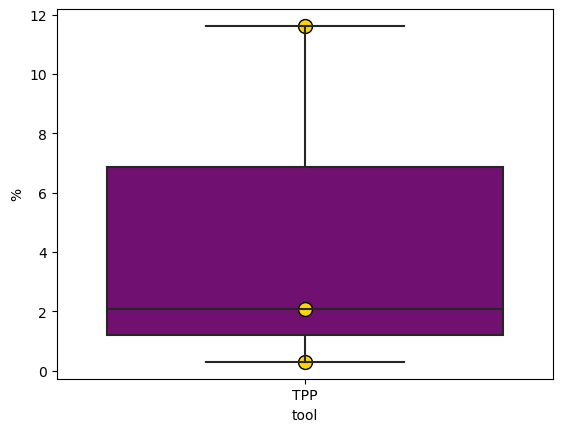

In [268]:
data=pd.DataFrame({"tool":["TPP","TPP","TPP"],"%":frqs_noncapsm})
fig, axs = plt.subplots(1,1)
sns.boxplot(data=data,x="tool",y="%",notch=False,color="purple")
plt.scatter([0,0,0],frqs_noncapsm,color="gold",s=100,edgecolors="black");
#plt.ylim(0,3)
plt.savefig("tpp_altpsmfrq_boxplot.svg")

In [ ]:
from plotly_upset.plotting import plot_upset

In [269]:
datasets=["PXD002057","PXD003594","PXD014258"]
dfs=[peptideprophet_filt_combined_datasets[dataset_name]["openprot"] for dataset_name in datasets]
dfsconc=pd.DataFrame()
for i,df in enumerate(dfs):
    a=df.loc[df["only altprots"]==True,"peptide"].drop_duplicates().to_frame()
    a[datasets[i]]=1
    a.set_index("peptide",inplace=True)
    #dfsconc=pd.concat([dfsconc,a],axis=0)
    dfsconc=dfsconc.merge(a,how="outer",left_index=True, right_index=True)
dfsconc.fillna(0,inplace=True)

In [274]:
#get sets of unique peptides noncanon prots to see ovrlap between samples
dfsconc[dfsconc.sum(axis=1)>1].shape, len(dfsconc)

((20, 3), 10090)

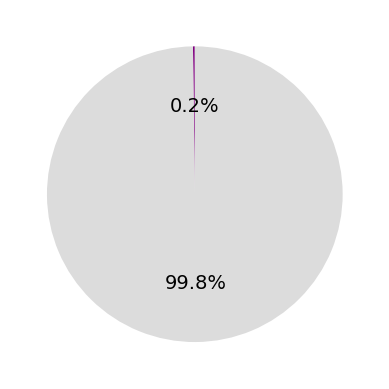

In [278]:
sizes=[len(dfsconc[dfsconc.sum(axis=1)>1]),len(dfsconc)]
labels=["",""] #in >1 dataset
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=90,colors=["purple","gainsboro"], textprops={'fontsize': 14});
plt.savefig("tpp_noncanpeprepr_pie.svg")

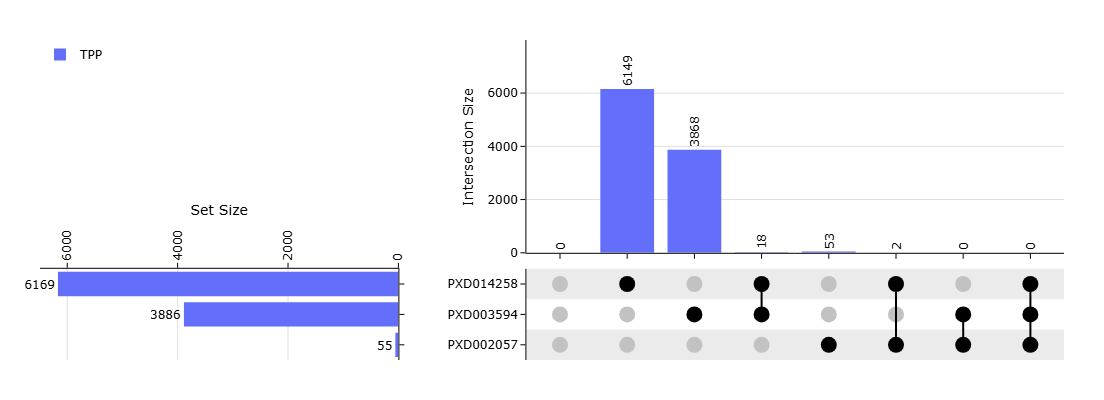

In [271]:
fig = plot_upset(
    dataframes=[dfsconc],
    legendgroups=["TPP"],
    marker_size=16,
)
fig.write_image("tpp_altpeptides_upset.svg")
fig.show()